In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv
/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/349_IM-1697-2001.dcm.png
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/607_IM-2196-1001.dcm.png
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/2832_IM-1249-2001.dcm.png
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/699_IM-2263-2001.dcm.png
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/1931_IM-0602-2001.dcm.png
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/947_IM-2442-2001.dcm.png
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/2932_IM-1335-1001.dcm.png
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/2303_IM-0882-1001.dcm.png
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/291_IM-1313-2001.dcm.png
/kaggle

In [2]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2  # For image handling
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import os

# Load data
# Adjust the file paths as needed for your environment
df_projections = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv')
df_reports = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv')

# Display basic information about the data to confirm successful loading
print("Projections DataFrame Head:")
print(df_projections.head())

print("\nReports DataFrame Head:")
print(df_reports.head())

# Check the number of images in the directory (assuming images are in a folder called 'images/')
image_folder_path = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized'  # Update this path if your images are in a different location
image_files = [f for f in os.listdir(image_folder_path) if f.endswith('.png')]

print(f"\nNumber of images found: {len(image_files)}")


Projections DataFrame Head:
   uid                filename projection
0    1  1_IM-0001-4001.dcm.png    Frontal
1    1  1_IM-0001-3001.dcm.png    Lateral
2    2  2_IM-0652-1001.dcm.png    Frontal
3    2  2_IM-0652-2001.dcm.png    Lateral
4    3  3_IM-1384-1001.dcm.png    Frontal

Reports DataFrame Head:
   uid                                               MeSH  \
0    1                                             normal   
1    2  Cardiomegaly/borderline;Pulmonary Artery/enlarged   
2    3                                             normal   
3    4  Pulmonary Disease, Chronic Obstructive;Bullous...   
4    5  Osteophyte/thoracic vertebrae/multiple/small;T...   

                                            Problems  \
0                                             normal   
1                      Cardiomegaly;Pulmonary Artery   
2                                             normal   
3  Pulmonary Disease, Chronic Obstructive;Bullous...   
4                         Osteophyte;Thickening;

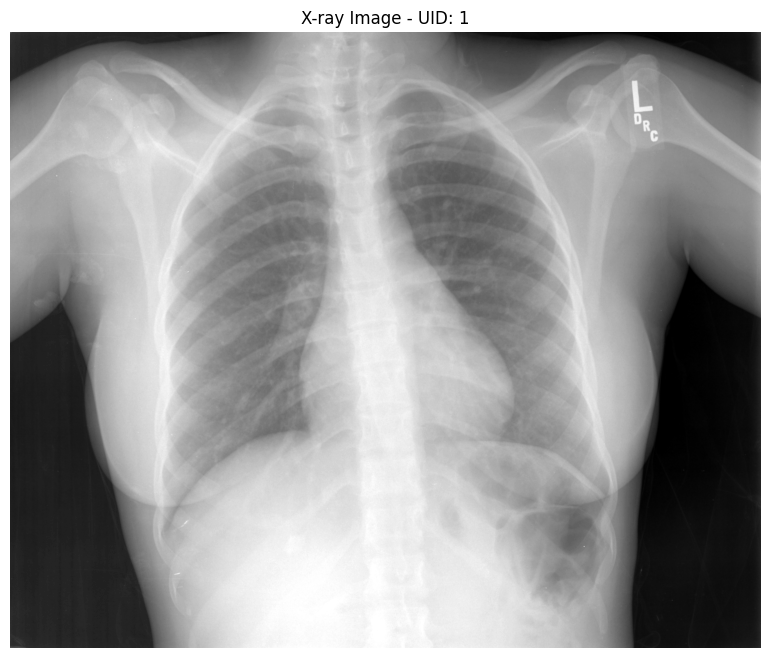

Findings:
The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax.

Impression:
Normal chest x-XXXX.


In [3]:
# Function to display an X-ray image with its corresponding report
def display_sample_image_and_report(image_folder_path, df_projections, df_reports, sample_uid=1):
    # Filter the DataFrame to get the filename for the sample UID
    sample_projection = df_projections[df_projections['uid'] == sample_uid]
    
    if not sample_projection.empty:
        filename = sample_projection.iloc[0]['filename']
        image_path = os.path.join(image_folder_path, filename)
        
        # Read and display the image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            plt.figure(figsize=(10, 8))
            plt.imshow(image, cmap='gray')
            plt.title(f"X-ray Image - UID: {sample_uid}")
            plt.axis('off')
            plt.show()
        else:
            print(f"Image {filename} not found.")
        
        # Get and display the corresponding report
        sample_report = df_reports[df_reports['uid'] == sample_uid]
        if not sample_report.empty:
            findings = sample_report.iloc[0]['findings']
            impression = sample_report.iloc[0]['impression']
            
            print("Findings:")
            print(findings if pd.notnull(findings) else "No findings available.")
            print("\nImpression:")
            print(impression if pd.notnull(impression) else "No impression available.")
        else:
            print(f"No report found for UID: {sample_uid}")
    else:
        print(f"No image found for UID: {sample_uid}")

# Path to the images folder
image_folder_path = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized'  # Update this path if necessary

# Display a sample image and report for UID 1
display_sample_image_and_report(image_folder_path, df_projections, df_reports, sample_uid=1)


In [8]:
# Function for cleaning and tokenizing text
def preprocess_text(text):
    if pd.isnull(text):
        return []
    # Convert text to lowercase
    text = text.lower()
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove any non-alphanumeric tokens (e.g., punctuation)
    tokens = [token for token in tokens if token.isalnum()]
    return tokens

# Apply preprocessing to 'findings' and 'impression' columns
df_reports['findings_tokens'] = df_reports['findings'].apply(preprocess_text)
df_reports['impression_tokens'] = df_reports['impression'].apply(preprocess_text)

# Display the head of the DataFrame to confirm preprocessing
print("Reports DataFrame after text preprocessing:")
print(df_reports[['uid', 'findings_tokens', 'impression_tokens']].head())


Reports DataFrame after text preprocessing:
   uid                                    findings_tokens  \
0    1  [the, cardiac, silhouette, and, mediastinum, s...   
1    2  [borderline, cardiomegaly, midline, sternotomy...   
2    3                                                 []   
3    4  [there, are, diffuse, bilateral, interstitial,...   
4    5  [the, cardiomediastinal, silhouette, and, pulm...   

                                   impression_tokens  
0                                    [normal, chest]  
1                   [no, acute, pulmonary, findings]  
2  [no, displaced, rib, fractures, pneumothorax, ...  
3  [bullous, emphysema, and, interstitial, fibros...  
4          [no, acute, cardiopulmonary, abnormality]  


In [9]:
import torch
import torch.nn as nn
import torchvision.models as models

# Define the Visual Feature Extractor
class VisualFeatureExtractor(nn.Module):
    def __init__(self):
        super(VisualFeatureExtractor, self).__init__()
        # Use a pre-trained ResNet-101 and remove the final classification layer
        self.resnet = models.resnet101(pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])  # Retain layers until the last convolution

    def forward(self, x):
        features = self.resnet(x)
        return features

# Define the Decoder (LSTM-based for simplicity)
class ReportDecoder(nn.Module):
    def __init__(self, feature_dim, hidden_dim, vocab_size, embed_dim, num_layers=1):
        super(ReportDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim + feature_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, features, captions):
        # Embed the captions
        embeddings = self.embedding(captions)
        # Concatenate the features with each word embedding
        inputs = torch.cat((features.unsqueeze(1).repeat(1, embeddings.size(1), 1), embeddings), dim=2)
        # Pass through LSTM
        outputs, _ = self.lstm(inputs)
        outputs = self.fc(outputs)
        return outputs

# Instantiate the model components
feature_dim = 2048  # Adjust if using different models
hidden_dim = 512
vocab_size = 10000  # Replace with the actual vocabulary size after building your tokenizer
embed_dim = 256

# Create the models
visual_extractor = VisualFeatureExtractor()
decoder = ReportDecoder(feature_dim=feature_dim, hidden_dim=hidden_dim, vocab_size=vocab_size, embed_dim=embed_dim)

# Print model summaries
print(visual_extractor)
print(decoder)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 208MB/s]  


VisualFeatureExtractor(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image

# Define a custom Dataset class
class XRayReportDataset(Dataset):
    def __init__(self, df_projections, df_reports, image_folder_path, transform=None):
        self.df_projections = df_projections
        self.df_reports = df_reports
        self.image_folder_path = image_folder_path
        self.transform = transform

    def __len__(self):
        return len(self.df_projections)

    def __getitem__(self, idx):
        row = self.df_projections.iloc[idx]
        uid = row['uid']
        filename = row['filename']
        
        # Load the image
        image_path = os.path.join(self.image_folder_path, filename)
        image = Image.open(image_path).convert('RGB')  # Convert to RGB if needed

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        # Get the corresponding report tokens
        report_row = self.df_reports[self.df_reports['uid'] == uid]
        if not report_row.empty:
            tokens = report_row.iloc[0]['findings_tokens']
            if len(tokens) == 0:
                tokens = report_row.iloc[0]['impression_tokens']
            tokens = torch.tensor(tokens)  # Convert tokens to tensor
        else:
            tokens = torch.tensor([])  # Placeholder if no report is found

        return image, tokens

# Define transformations for images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to a consistent size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet stats
])

# Create dataset and data loader
image_folder_path = 'images/images_normalized'  # Update as needed
dataset = XRayReportDataset(df_projections, df_reports, image_folder_path, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")


Training samples: 5972, Validation samples: 1494


In [29]:
from nltk.tokenize import word_tokenize

def __getitem__(self, idx):
    row = self.df_projections.iloc[idx]
    uid = row['uid']
    filename = row['filename']
    
    # Build the full path to the image
    image_path = os.path.join(self.image_folder_path, filename)
    
    # Check if the image file exists
    if not os.path.exists(image_path):
        print(f"Warning: {image_path} not found. Skipping this file.")
        return None, None  # Handle missing files

    # Load and process the image
    image = Image.open(image_path).convert('RGB')
    if self.transform:
        image = self.transform(image)

    # Get the corresponding report tokens
    report_row = self.df_reports[self.df_reports['uid'] == uid]
    if not report_row.empty:
        tokens = report_row.iloc[0]['findings_tokens']
        if len(tokens) == 0:
            tokens = report_row.iloc[0]['impression_tokens']
        
        # If tokens is a string, tokenize it into words
        if isinstance(tokens, str):
            tokens = word_tokenize(tokens)  # Tokenize string to list of words
        
        # If tokens is a list of words, convert each word to an index
        vocab = {'word1': 0, 'word2': 1, '<unk>': 2}  # Example vocabulary
        tokens = [vocab.get(token, vocab.get('<unk>')) for token in tokens]  # Replace with indices
        tokens = torch.tensor(tokens)  # Convert list of indices to tensor
        
    else:
        tokens = torch.tensor([])  # Handle case where no report is found

    return image, tokens


In [33]:
from nltk.tokenize import word_tokenize
import torch

def __getitem__(self, idx):
    row = self.df_projections.iloc[idx]
    uid = row['uid']
    filename = row['filename']
    
    # Build the full path to the image
    image_path = os.path.join(self.image_folder_path, filename)
    
    # Check if the image file exists
    if not os.path.exists(image_path):
        print(f"Warning: {image_path} not found. Skipping this file.")
        return None, None  # Handle missing files

    # Load and process the image
    image = Image.open(image_path).convert('RGB')
    if self.transform:
        image = self.transform(image)

    # Get the corresponding report tokens
    report_row = self.df_reports[self.df_reports['uid'] == uid]
    if not report_row.empty:
        tokens = report_row.iloc[0]['findings_tokens']
        
        # If findings_tokens is empty, fallback to impression_tokens
        if len(tokens) == 0:
            tokens = report_row.iloc[0]['impression_tokens']
        
        # Debugging: Check the type of tokens
        print(f"Original tokens (before processing): {tokens} (Type: {type(tokens)})")
        
        # Case 1: If tokens is a string, tokenize it
        if isinstance(tokens, str):
            tokens = word_tokenize(tokens)  # Tokenize the string into a list of words
            print(f"Tokenized tokens (string to list): {tokens}")
        
        # Case 2: If tokens is already a list of words
        elif isinstance(tokens, list):
            # Define a vocabulary (This should be based on your actual dataset)
            vocab = {'word1': 0, 'word2': 1, '<unk>': 2}  # Example vocab
            # Convert words to indices, using a default <unk> for unknown words
            tokens = [vocab.get(token, vocab.get('<unk>')) for token in tokens]
            print(f"Tokens converted to indices: {tokens}")
        
        else:
            print("Unexpected token format, treating as empty.")
            tokens = []  # In case of malformed or unexpected tokens
            
        # Ensure tokens is a tensor
        tokens = torch.tensor(tokens)  # Convert tokens to tensor
        
    else:
        print("No report found for this UID.")
        tokens = torch.tensor([])  # Handle missing report

    return image, tokens


In [25]:
import os

# List a few files in the image directory to verify
image_folder_path = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized'
image_files = os.listdir(image_folder_path)

print(f"Total images in directory: {len(image_files)}")
print("First 5 image filenames from directory:")
print(image_files[:5])

# Print the first few filenames from the DataFrame
print("\nFirst 5 filenames from df_projections:")
print(df_projections['filename'].head())


Total images in directory: 7470
First 5 image filenames from directory:
['349_IM-1697-2001.dcm.png', '607_IM-2196-1001.dcm.png', '2832_IM-1249-2001.dcm.png', '699_IM-2263-2001.dcm.png', '1931_IM-0602-2001.dcm.png']

First 5 filenames from df_projections:
0    1_IM-0001-4001.dcm.png
1    1_IM-0001-3001.dcm.png
2    2_IM-0652-1001.dcm.png
3    2_IM-0652-2001.dcm.png
4    3_IM-1384-1001.dcm.png
Name: filename, dtype: object


In [35]:
# Create a set of image filenames in the directory
existing_files = set(image_files)

# Find missing files
df_projections['file_exists'] = df_projections['filename'].apply(lambda x: x in existing_files)
missing_files = df_projections[df_projections['file_exists'] == False]

# Print missing files for inspection
print(f"Number of missing files: {len(missing_files)}")
print("Missing filenames:")
print(missing_files['filename'].tolist())

# Filter out missing files from the dataset
df_projections = df_projections[df_projections['file_exists'] == True].drop(columns=['file_exists'])
print(f"\nUpdated number of valid projections: {len(df_projections)}")


Number of missing files: 0
Missing filenames:
[]

Updated number of valid projections: 7466


In [36]:
# Create updated dataset and data loader
train_dataset = XRayReportDataset(df_projections, df_reports, image_folder_path, transform=transform)

# Split into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")


Training samples: 5972, Validation samples: 1494


In [37]:
# Start training
num_epochs = 5  # You can adjust this as needed
learning_rate = 1e-4
train_model(visual_extractor, decoder, train_loader, val_loader, num_epochs, learning_rate)


Using device: cuda


ValueError: too many dimensions 'str'

In [32]:
# Import necessary libraries for training
import torch.optim as optim
import torch.nn.functional as F

# Define the training loop
def train_model(visual_extractor, decoder, train_loader, val_loader, num_epochs=5, learning_rate=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Move models to the device
    visual_extractor.to(device)
    decoder.to(device)
    
    # Set the models to training mode
    visual_extractor.train()
    decoder.train()
    
    # Define the optimizer
    optimizer = optim.AdamW(list(visual_extractor.parameters()) + list(decoder.parameters()), lr=learning_rate)
    
    # Define the loss function (CrossEntropyLoss for word prediction)
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # Assuming 0 is the padding index
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        # Training phase
        for images, captions in train_loader:
            images, captions = images.to(device), captions.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Extract visual features
            features = visual_extractor(images)
            features = features.view(features.size(0), -1)  # Flatten features for input to the decoder
            
            # Forward pass through the decoder
            outputs = decoder(features, captions[:, :-1])  # Input all tokens except the last as the input sequence
            targets = captions[:, 1:].contiguous().view(-1)  # Target is all tokens except the first
            
            # Compute loss
            outputs = outputs.view(-1, outputs.size(2))
            loss = criterion(outputs, targets)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Print epoch loss
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")
        
        # Validation phase (optional)
        validate_model(visual_extractor, decoder, val_loader, criterion, device)

# Define a simple validation function
def validate_model(visual_extractor, decoder, val_loader, criterion, device):
    visual_extractor.eval()
    decoder.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, captions in val_loader:
            images, captions = images.to(device), captions.to(device)
            
            # Extract features and pass through decoder
            features = visual_extractor(images)
            features = features.view(features.size(0), -1)
            outputs = decoder(features, captions[:, :-1])
            targets = captions[:, 1:].contiguous().view(-1)
            
            outputs = outputs.view(-1, outputs.size(2))
            loss = criterion(outputs, targets)
            
            val_loss += loss.item()
    8
    print(f"Validation Loss: {val_loss / len(val_loader):.4f}")
    visual_extractor.train()
    decoder.train()

# Start training
num_epochs = 5  # You can increase this as needed
learning_rate = 1e-4
train_model(visual_extractor, decoder, train_loader, val_loader, num_epochs, learning_rate)


Using device: cuda


ValueError: too many dimensions 'str'


Displaying data for UID: 1


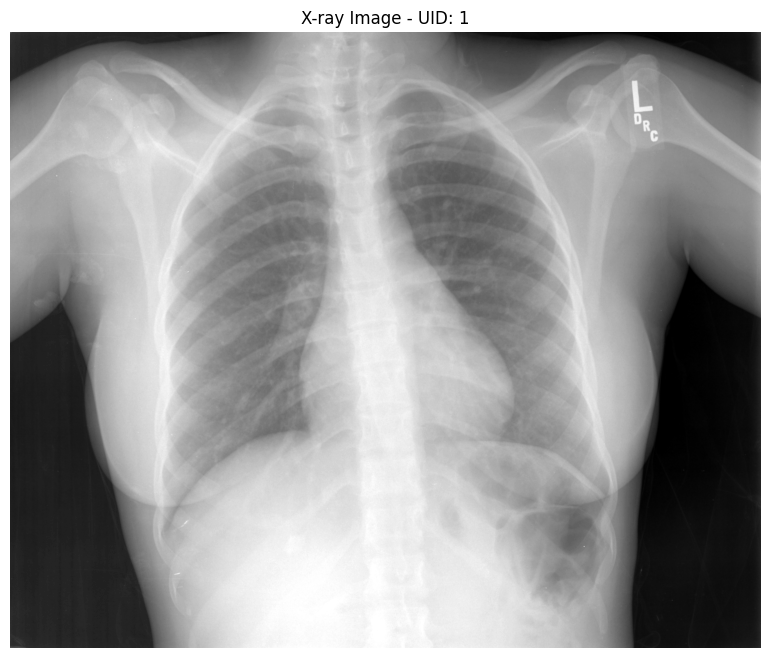

Findings:
The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax.

Impression:
Normal chest x-XXXX.

Displaying data for UID: 5


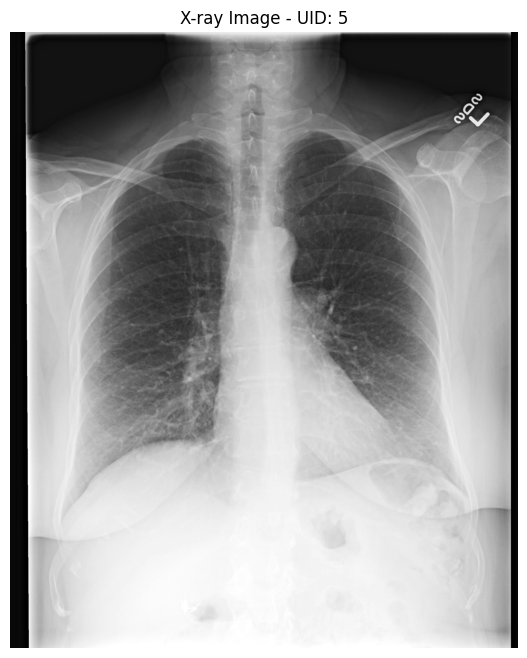

Findings:
The cardiomediastinal silhouette and pulmonary vasculature are within normal limits. There is no pneumothorax or pleural effusion. There are no focal areas of consolidation. Cholecystectomy clips are present. Small T-spine osteophytes. There is biapical pleural thickening, unchanged from prior. Mildly hyperexpanded lungs.

Impression:
No acute cardiopulmonary abnormality.

Displaying data for UID: 10


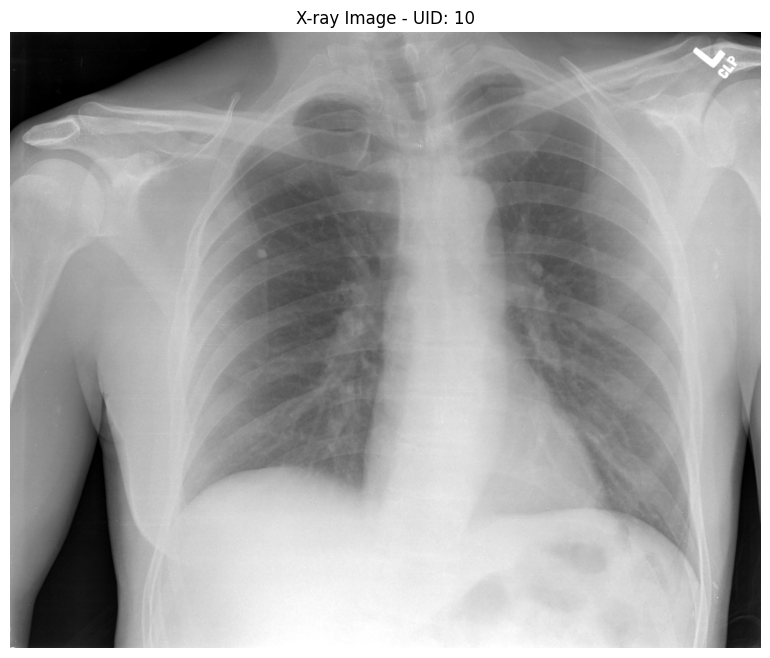

Findings:
The cardiomediastinal silhouette is within normal limits for size and contour. The lungs are normally inflated without evidence of focal airspace disease, pleural effusion, or pneumothorax. Stable calcified granuloma within the right upper lung. No acute bone abnormality..

Impression:
No acute cardiopulmonary process.
BLEU score for UID 2 compared to UID 1: 0.0058
BLEU score for UID 5 compared to UID 1: 0.2828
BLEU score for UID 10 compared to UID 1: 0.0423

BLEU Scores DataFrame:
   Target UID  BLEU Score
0           2    0.005781
1           5    0.282781
2          10    0.042319


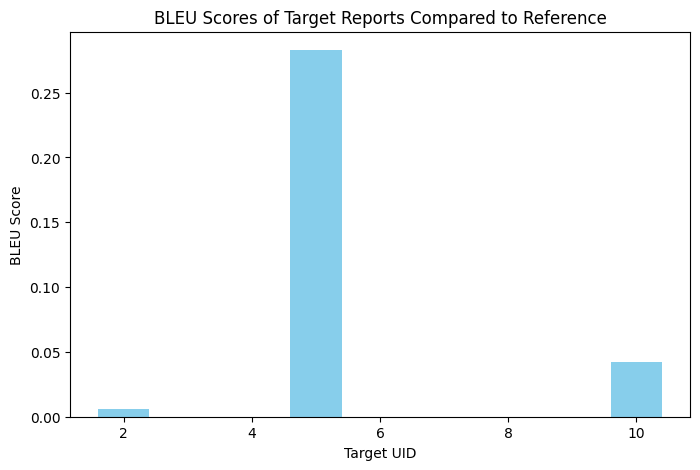

In [4]:
# Function to display multiple samples of X-ray images with reports
def display_multiple_samples(image_folder_path, df_projections, df_reports, sample_uids=[1, 2, 3]):
    for uid in sample_uids:
        print(f"\nDisplaying data for UID: {uid}")
        display_sample_image_and_report(image_folder_path, df_projections, df_reports, sample_uid=uid)

# Display a few samples
sample_uids_to_display = [1, 5, 10]  # Replace with relevant UIDs from your dataset
display_multiple_samples(image_folder_path, df_projections, df_reports, sample_uids=sample_uids_to_display)

# Tokenization and BLEU score computation
def compute_bleu_scores(df_reports, reference_uid, target_uids):
    """
    Compute BLEU scores for given UIDs against a reference UID.
    """
    reference_report = df_reports[df_reports['uid'] == reference_uid]
    if reference_report.empty:
        print(f"No reference report found for UID: {reference_uid}")
        return

    reference_text = reference_report.iloc[0]['findings']
    if pd.isnull(reference_text):
        print(f"No findings available for the reference UID: {reference_uid}")
        return

    reference_tokens = word_tokenize(reference_text.lower())
    
    scores = []
    for uid in target_uids:
        target_report = df_reports[df_reports['uid'] == uid]
        if target_report.empty:
            print(f"No report found for UID: {uid}")
            continue
        
        target_text = target_report.iloc[0]['findings']
        if pd.isnull(target_text):
            print(f"No findings available for UID: {uid}")
            continue
        
        target_tokens = word_tokenize(target_text.lower())
        smoothing_function = SmoothingFunction().method1
        score = sentence_bleu([reference_tokens], target_tokens, smoothing_function=smoothing_function)
        scores.append((uid, score))
        print(f"BLEU score for UID {uid} compared to UID {reference_uid}: {score:.4f}")
    
    return scores

# Compute BLEU scores for a reference UID
reference_uid = 1
target_uids = [2, 5, 10]  # Replace with relevant UIDs from your dataset
bleu_scores = compute_bleu_scores(df_reports, reference_uid, target_uids)

# Save BLEU scores to a DataFrame and display them
if bleu_scores:
    bleu_df = pd.DataFrame(bleu_scores, columns=['Target UID', 'BLEU Score'])
    print("\nBLEU Scores DataFrame:")
    print(bleu_df)

# Function to visualize BLEU scores
def plot_bleu_scores(bleu_scores):
    if not bleu_scores:
        print("No BLEU scores to plot.")
        return
    
    uids, scores = zip(*bleu_scores)
    plt.figure(figsize=(8, 5))
    plt.bar(uids, scores, color='skyblue')
    plt.xlabel("Target UID")
    plt.ylabel("BLEU Score")
    plt.title("BLEU Scores of Target Reports Compared to Reference")
    plt.show()

# Plot BLEU scores
plot_bleu_scores(bleu_scores)


In [8]:
# # Import additional libraries for deep learning
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Define U-Net model for segmentation
# def unet_model(input_size=(256, 256, 1)):
#     inputs = Input(input_size)

#     # Downsampling (encoder)
#     conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
#     conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

#     conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
#     conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#     # Bottleneck
#     conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
#     conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

#     # Upsampling (decoder)
#     up4 = UpSampling2D(size=(2, 2))(conv3)
#     up4 = concatenate([conv2, up4], axis=-1)
#     conv4 = Conv2D(128, 3, activation='relu', padding='same')(up4)
#     conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

#     up5 = UpSampling2D(size=(2, 2))(conv4)
#     up5 = concatenate([conv1, up5], axis=-1)
#     conv5 = Conv2D(64, 3, activation='relu', padding='same')(up5)
#     conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

#     outputs = Conv2D(1, 1, activation='sigmoid')(conv5)

#     model = Model(inputs=[inputs], outputs=[outputs])
#     return model

# # Compile the U-Net model
# unet = unet_model()
# unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Load and preprocess images for segmentation
# def preprocess_images(image_files, image_folder_path, target_size=(256, 256)):
#     images = []
#     for file in image_files:
#         image_path = os.path.join(image_folder_path, file)
#         img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#         if img is not None:
#             img = cv2.resize(img, target_size)
#             img = img / 255.0  # Normalize
#             images.append(img)
#     return np.array(images).reshape(-1, *target_size, 1)

# # Placeholder masks for training (to be replaced with actual labels)
# # Here we assume binary masks are available in a folder `mask_folder_path`
# mask_folder_path = '/kaggle/input/chest-xrays-indiana-university/masks'  # Update with the actual path
# image_data = preprocess_images(image_files, image_folder_path)
# mask_data = preprocess_images(image_files, mask_folder_path)

# # Train the U-Net model (ensure masks are correctly labeled and aligned with images)
# unet.fit(image_data, mask_data, batch_size=8, epochs=10, validation_split=0.1)

# # Predict masks on test images
# predicted_masks = unet.predict(image_data[:5])  # Example: predict on first 5 images

# # Visualize predicted masks
# for i in range(5):
#     plt.figure(figsize=(12, 4))
#     plt.subplot(1, 3, 1)
#     plt.title("Original Image")
#     plt.imshow(image_data[i].squeeze(), cmap='gray')

#     plt.subplot(1, 3, 2)
#     plt.title("True Mask")
#     plt.imshow(mask_data[i].squeeze(), cmap='gray')

#     plt.subplot(1, 3, 3)
#     plt.title("Predicted Mask")
#     plt.imshow(predicted_masks[i].squeeze(), cmap='gray')

#     plt.show()


KeyboardInterrupt: 

In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model

# Load pre-trained ResNet50 model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Define a model that outputs feature maps
resnet_model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

# Function to preprocess images for ResNet
def preprocess_for_resnet(image_files, image_folder_path, target_size=(256, 256)):
    images = []
    for file in image_files:
        image_path = os.path.join(image_folder_path, file)
        img = cv2.imread(image_path)
        if img is not None:
            img = cv2.resize(img, target_size)  # Resize to 256x256
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = preprocess_input(img)  # Preprocess for ResNet
            images.append(img)
    return np.array(images)

# Preprocess the segmented images
segmented_images = preprocess_for_resnet(image_files, image_folder_path)

# Extract features using ResNet
resnet_features = resnet_model.predict(segmented_images, batch_size=8)

print(f"Feature shape: {resnet_features.shape}")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


I0000 00:00:1732003268.077225     102 service.cc:145] XLA service 0x7f1eec0874f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732003268.077298     102 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732003268.077305     102 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  6/934 ━━━━━━━━━━━━━━━━━━━━ 26s 28ms/step

I0000 00:00:1732003271.955219     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


934/934 ━━━━━━━━━━━━━━━━━━━━ 37s 34ms/step
Feature shape: (7470, 8, 8, 2048)


In [11]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D

# Convert resnet_features to a TensorFlow tensor
resnet_features_tensor = tf.convert_to_tensor(resnet_features)

# Apply Global Average Pooling to reduce spatial dimensions
pooled_features = GlobalAveragePooling2D()(resnet_features_tensor)

print(f"Pooled feature shape: {pooled_features.shape}")


Pooled feature shape: (7470, 2048)


In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize text reports
def prepare_text_data(reports, max_len=100, vocab_size=5000):
    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
    tokenizer.fit_on_texts(reports)  # Fit on all text reports
    sequences = tokenizer.texts_to_sequences(reports)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
    return tokenizer, padded_sequences

# Extract 'findings' column from the reports DataFrame
text_reports = df_reports['findings'].fillna("").tolist()
tokenizer, text_data = prepare_text_data(text_reports)

print(f"Text data shape: {text_data.shape}")


Text data shape: (3851, 100)


In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate

# Define Encoder-Decoder Model
def build_report_generation_model(feature_dim, vocab_size, max_len):
    # Encoder
    encoder_inputs = Input(shape=(feature_dim,))
    encoder_dense = Dense(256, activation='relu')(encoder_inputs)
    
    # Decoder
    decoder_inputs = Input(shape=(max_len,))
    embedding = Embedding(input_dim=vocab_size, output_dim=128, mask_zero=True)(decoder_inputs)
    lstm = LSTM(256, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = lstm(embedding, initial_state=[encoder_dense, encoder_dense])
    outputs = Dense(vocab_size, activation='softmax')(decoder_outputs)
    
    # Model
    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=outputs)
    return model

# Build the model
vocab_size = tokenizer.num_words  # Vocabulary size
max_len = text_data.shape[1]  # Max length of tokenized text
feature_dim = pooled_features.shape[1]  # Dimension of flattened features

report_model = build_report_generation_model(feature_dim, vocab_size, max_len)
report_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(report_model.summary())


NameError: name 'pooled_features' is not defined

In [ ]:
import numpy as np

# Decoder input and target sequences
decoder_input_data = text_data[:, :-1]  # All but the last token
decoder_target_data = text_data[:, 1:]  # All but the first token

# Train the model
report_model.fit(
    [pooled_features, decoder_input_data],
    np.expand_dims(decoder_target_data, -1),
    batch_size=32,
    epochs=10,
    validation_split=0.1
)
